In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from numba import njit
from tqdm import tqdm
sns.set_theme(style='ticks', context='notebook', font_scale=1.1)

## Section 1: Behavior

In [2]:
## Load data.
data = concat([read_csv(os.path.join('data', session, 'pgng.csv'))
               for session in ['s1','s2','s3','s4']])

## Restrict participants.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    103
2     94
3     92
4     89
Name: subject, dtype: int64


### 1.1 Learning curves

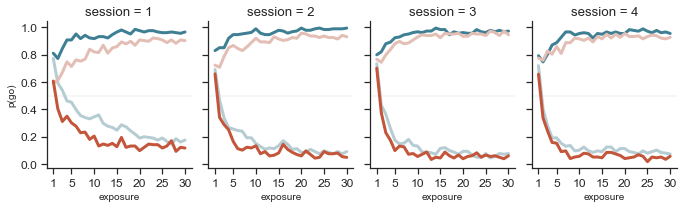

In [3]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3,4], aspect=0.8)

## Define aesthetics.
palette = sns.diverging_palette(220, 20, n=4)
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, 
      lw=3, errorbar=None)

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=np.append(1, np.arange(5,31,5)))
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

### 1.2 Temporal stability

In [4]:
from itertools import combinations

## Define parameters.
n_iter = 5000
sessions = [1,2,3,4]
pairs = list(combinations(sessions, 2))

## Define convenience functions.
def mad(x):
    """Median absolute difference."""
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

def cohens_d(x, popmean=0):
    """Cohen's D for one-sample median."""
    return np.abs(np.nanmedian(x) - popmean) / (mad(x) / 0.6745)

def ttest_rel(a,b):
    delta = a - b
    denom = (mad(delta) / 0.6745) / np.sqrt(np.sum(~np.isnan(delta)))
    return np.median(delta) / denom

#### Accuracy

100%|██████████| 5001/5001 [01:23<00:00, 59.78it/s]


Median[s1]  Median[s2]  Cohen's D   tval   pval
s1 s2                                                 
1  2        0.850       0.929      0.792 -7.677  0.000
   3        0.850       0.946      0.909 -8.720  0.000
   4        0.850       0.946      0.858 -8.099  0.000
2  3        0.929       0.946      0.289 -2.712  0.051
   4        0.929       0.946      0.193 -1.766  0.301
3  4        0.946       0.946      0.112 -1.030  0.897

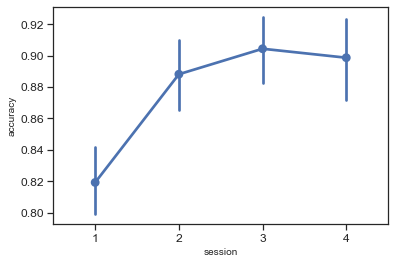

In [5]:
np.random.seed(47404)

## 
pivot = data.pivot_table('accuracy', 'subject', 'session')
gb = pivot.melt(ignore_index=False, value_name='accuracy')

## Compute summary statistics.
summary = []
for j, (a, b) in enumerate(pairs): 
    summary.append({
        's1': a, 
        's2': b, 
        'Median[s1]': pivot[a].median(), 
        'Median[s2]': pivot[b].median(),
        "Cohen's D": cohens_d((pivot[a] - pivot[b]).dropna())
    })
summary = DataFrame(summary)

## Compute t-tests.
tval = np.zeros((n_iter+1, len(pairs)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle membership.
    if i: pivot = pivot.T.apply(np.random.permutation).T
    
    ## Iterate over session pairs.
    for j, (a, b) in enumerate(pairs): 
        tval[i,j] = ttest_rel(*pivot[[a,b]].dropna().values.T)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['tval'] = tval; summary['pval'] = pval

## Plot.
ax = sns.pointplot(x='session', y='accuracy', data=gb)

## Return information.
summary.set_index(['s1','s2']).round(3)

#### Go bias

In [6]:
np.random.seed(47404)

## 
pivot = data.pivot_table('choice', 'subject', 'session') - 0.5
gb = pivot.melt(ignore_index=False, value_name='choice')

## Compute summary statistics.
summary = DataFrame(pivot.median().T).rename(columns={0: 'Median'})

## Compute t-tests.
tval = np.zeros((n_iter+1, len(sessions)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle signs.
    if i: pivot = pivot.apply(lambda x: x * np.random.choice([1,-1], x.size, replace=True))
    
    ## Iterate over session pairs.
    for j, s in enumerate(sessions): 
        tval[i,j] = np.nanmedian(pivot[s].values)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['pval'] = pval

## Return summary.
summary.round(3)

100%|██████████| 5001/5001 [00:08<00:00, 577.27it/s]


,Median,pval
session,,
1,0.058,0.000
2,0.025,0.001
3,0.021,0.003
4,0.017,0.037


100%|██████████| 5001/5001 [01:46<00:00, 46.85it/s]


Median[s1]  Median[s2]  Cohen's D   tval   pval
s1 s2                                                 
1  2        0.558       0.525      0.337  3.270  0.005
   3        0.558       0.521      0.674  6.470  0.000
   4        0.558       0.517      0.674  6.363  0.000
2  3        0.525       0.521      0.289  2.712  0.062
   4        0.525       0.517      0.506  4.636  0.001
3  4        0.521       0.517      0.225  2.061  0.310

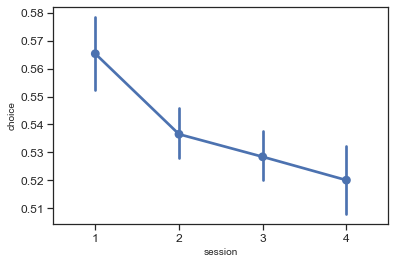

In [7]:
np.random.seed(47404)

## 
pivot = data.pivot_table('choice', 'subject', 'session')
gb = pivot.melt(ignore_index=False, value_name='choice')

## Compute summary statistics.
summary = []
for j, (a, b) in enumerate(pairs): 
    summary.append({'s1': a, 's2': b, 'Median[s1]': pivot[a].median(), 'Median[s2]': pivot[b].median(),
        "Cohen's D": cohens_d((pivot[a] - pivot[b]).dropna())})
summary = DataFrame(summary)

## Compute t-tests.
tval = np.zeros((n_iter+1, len(pairs)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle membership.
    if i: pivot = pivot.T.apply(np.random.permutation).T
    
    ## Iterate over session pairs.
    for j, (a, b) in enumerate(pairs): 
        tval[i,j] = ttest_rel(*pivot[[a,b]].dropna().values.T)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['tval'] = tval; summary['pval'] = pval

## Plot.
ax = sns.pointplot(x='session', y='choice', data=gb)

## Return summary.
summary.set_index(['s1','s2']).round(3)

#### Pavlovian bias

In [8]:
np.random.seed(47404)

## 
pivot = data.pivot_table('choice','subject',['valence','session'])
pivot = pivot['win'] - pivot['lose']
gb = pivot.melt(ignore_index=False, value_name='choice')

## Compute summary statistics.
summary = DataFrame(pivot.median().T).rename(columns={0: 'Median'})

## Compute t-tests.
tval = np.zeros((n_iter+1, len(sessions)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle signs.
    if i: pivot = pivot.apply(lambda x: x * np.random.choice([1,-1], x.size, replace=True))
    
    ## Iterate over session pairs.
    for j, s in enumerate(sessions): 
        tval[i,j] = np.nanmedian(pivot[s].values)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['pval'] = pval

## Return summary.
summary.round(3)

100%|██████████| 5001/5001 [00:13<00:00, 374.15it/s]


,Median,pval
session,,
1,0.092,0.000
2,0.017,0.113
3,0.017,0.139
4,0.008,0.278


In [9]:
np.random.seed(47404)

## 
pivot = data.pivot_table('choice','subject',['valence','session'])
pivot = pivot['win'] - pivot['lose']
gb = pivot.melt(ignore_index=False, value_name='choice')

## Compute summary statistics.
summary = []
for j, (a, b) in enumerate(pairs): 
    summary.append({
        's1': a, 
        's2': b, 
        'Median[s1]': pivot[a].median(), 
        'Median[s2]': pivot[b].median(),
        "Cohen's D": cohens_d((pivot[a] - pivot[b]).dropna())
    })
summary = DataFrame(summary)

## Compute t-tests.
tval = np.zeros((n_iter+1, len(pairs)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle membership.
    if i: pivot = pivot.T.apply(np.random.permutation).T
    
    ## Iterate over session pairs.
    for j, (a, b) in enumerate(pairs): 
        tval[i,j] = ttest_rel(*pivot[[a,b]].dropna().values.T)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['tval'] = tval; summary['pval'] = pval

## Return summary.
summary.round(3)

100%|██████████| 5001/5001 [01:34<00:00, 52.73it/s]


,s1,s2,Median[s1],Median[s2],Cohen's D,tval,pval
0,1,2,0.092,0.017,0.495,4.796,0.001
1,1,3,0.092,0.017,0.899,8.626,0.000
2,1,4,0.092,0.008,0.867,8.181,0.000
3,2,3,0.017,0.017,0.169,1.582,0.586
4,2,4,0.017,0.008,0.270,2.473,0.199
5,3,4,0.017,0.008,0.096,0.883,0.996


#### Congruency effect

In [10]:
np.random.seed(47404)

pivot = data.pivot_table('accuracy','subject',['robot','session'])
pivot = pivot[['gw','ngal']].T.groupby(level=-1).mean().T -\
        pivot[['ngw','gal']].T.groupby(level=-1).mean().T
gb = pivot.melt(ignore_index=False, value_name='accuracy')

## Compute summary statistics.
summary = DataFrame(pivot.median().T).rename(columns={0: 'Median'})

## Compute t-tests.
tval = np.zeros((n_iter+1, len(sessions)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle signs.
    if i: pivot = pivot.apply(lambda x: x * np.random.choice([1,-1], x.size, replace=True))
    
    ## Iterate over session pairs.
    for j, s in enumerate(sessions): 
        tval[i,j] = np.nanmedian(pivot[s].values)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['pval'] = pval

## Return summary.
summary.round(3)

100%|██████████| 5001/5001 [00:09<00:00, 504.78it/s]


,Median,pval
session,,
1,0.092,0.000
2,0.017,0.113
3,0.017,0.141
4,0.008,0.293


100%|██████████| 5001/5001 [01:31<00:00, 54.86it/s]


Median[s1]  Median[s2]  Cohen's D   tval   pval
s1 s2                                                 
1  2        0.092       0.017      0.495  4.796  0.001
   3        0.092       0.017      0.899  8.626  0.000
   4        0.092       0.008      0.867  8.181  0.000
2  3        0.017       0.017      0.169  1.582  0.585
   4        0.017       0.008      0.270  2.473  0.200
3  4        0.017       0.008      0.096  0.883  0.996

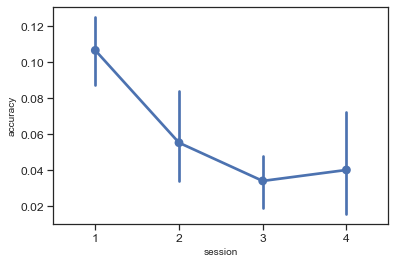

In [11]:
np.random.seed(47404)

pivot = data.pivot_table('accuracy','subject',['robot','session'])
pivot = pivot[['gw','ngal']].T.groupby(level=-1).mean().T -\
        pivot[['ngw','gal']].T.groupby(level=-1).mean().T
gb = pivot.melt(ignore_index=False, value_name='accuracy')

## Compute summary statistics.
summary = []
for j, (a, b) in enumerate(pairs): 
    summary.append({
        's1': a, 
        's2': b, 
        'Median[s1]': pivot[a].median(), 
        'Median[s2]': pivot[b].median(),
        "Cohen's D": cohens_d((pivot[a] - pivot[b]).dropna())
    })
summary = DataFrame(summary)

## Compute t-tests.
tval = np.zeros((n_iter+1, len(pairs)))
for i in tqdm(range(len(tval))):
    
    ## Shuffle membership.
    if i: pivot = pivot.T.apply(np.random.permutation).T
    
    ## Iterate over session pairs.
    for j, (a, b) in enumerate(pairs): 
        tval[i,j] = ttest_rel(*pivot[[a,b]].dropna().values.T)
        
## Compute p-values.
tval, null = tval[0], tval[1:]
null = null[np.arange(len(null)), np.argmax(np.abs(null), axis=1)]
pval = (np.sum(np.abs(tval) < np.abs(null).reshape(-1,1), axis=0) + 1) / (n_iter + 1)
summary['tval'] = tval; summary['pval'] = pval

## Plot.
ax = sns.pointplot(x='session', y='accuracy', data=gb)

## Return information.
summary.set_index(['s1','s2']).round(3)

### 1.2 Individual-differences

In [12]:
## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, np.arange(0.6,1.0,0.1))

## Calculate proportion of participants in each bin.
gb = gb.groupby(['robot','session','score']).subject.count().reset_index()
gb['prop'] = gb.groupby(['robot','session']).subject.transform(lambda x: x / x.sum())
gb['cumprop'] = gb.groupby(['robot','session']).prop.transform(np.cumsum)

## Initialize canvas.
fig, axes = plt.subplots(1, 4, figsize=(10,3))
palette = sns.color_palette('crest_r', n_colors=gb.score.nunique()).as_hex()
palette = ['#234f81', '#4c658c', '#6d7b96', '#8d93a1', '#ababab']

## Iteratively plot.
for i, (ax, robot) in enumerate(zip(axes, ['gw','gal','ngw','ngal'])):

    ## Stacked barchart. 
    for score, color in zip(np.unique(gb.score)[::-1], palette):    
    
        ## Plot scores.
        q = f'robot == "{robot}" and score == {score}'
        sns.barplot(x='cumprop', y='session', data=gb.query(q), order=[1,2,3,4], 
                    palette=np.repeat(color, 4), orient='h', ax=ax)
    
    ## Annotations.
    for y, session in enumerate([1,2,3,4]):
        v = gb.set_index(['robot','session','score']).loc[(robot,session,4)].prop
        ax.annotate('%0.1f%%' %(v*1e2), (0,0), (1-v/2, y), ha='center', va='center',
                    color='w', fontsize=10)
    
    ## Adjust x-axis.
    ax.set(xlim=(0,1), xticks=np.linspace(0,1,6))
    ax.set_xticklabels(['%0.0f%%' %p for p in np.linspace(0,1e2,6)], fontsize=9, color='0.3')
    ax.set_xlabel('Percent of sample', fontsize=9, color='0.3')

    ## Adjust y-axis.
    ax.set(ylabel='', yticks=np.arange(4), yticklabels=[])
    if not i: ax.set_yticklabels(['Day 0', 'Day 3', 'Day 14', 'Day 28'], ha='right',
                                 fontsize=11, color='0.3')
    
    ## Adjust title.
    ax.set_title(robot.upper(), fontsize=14, color='0.3')
    
    ## Modify ax spines.
    ax.yaxis.set_tick_params(pad=1)
    ax.spines['bottom'].set(linewidth=1, color='0.3')
    ax.tick_params(bottom=True, left=False, color='0.3', length=4, width=1)
    sns.despine(ax=ax, left=True, right=True, top=True, bottom=False)
    
plt.tight_layout()